## 載入套件

In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## 下載測試用圖片

In [5]:
content_path = tf.keras.utils.get_file('content.jpg', 'https://i.imgur.com/SGcqzia.jpg')
style_path = tf.keras.utils.get_file('style.jpg','https://i.imgur.com/bqNSFt6.jpg')

212992/208597 [==============================] - 0s 0us/step


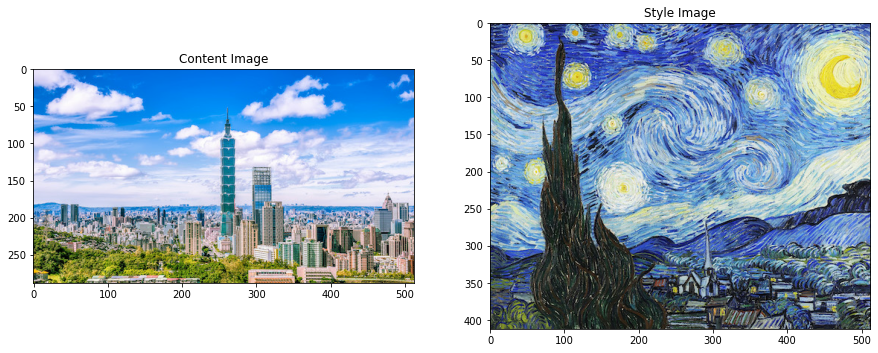

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


In [7]:
# Load a VGG19 and test run it on our image to ensure it's used correctly:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('lakeside', 0.102724105),
 ('obelisk', 0.09732696),
 ('fountain', 0.08038683),
 ('pole', 0.07651128),
 ('dock', 0.038048536)]

In [8]:
# Now load a VGG19 without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
# Choose intermediate layers from the network to represent the style and content of the image:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

In [10]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
# 建立模型
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 412, 512, 64)
  min:  0.0
  max:  791.3026
  mean:  32.346138

block2_conv1
  shape:  (1, 206, 256, 128)
  min:  0.0
  max:  3601.2947
  mean:  199.99915

block3_conv1
  shape:  (1, 103, 128, 256)
  min:  0.0
  max:  8494.076
  mean:  195.34305

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  18576.955
  mean:  727.58295

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3885.0852
  mean:  58.424004



In [12]:
# Calculate style
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


In [13]:
# Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [14]:
# When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.16688527
    max:  57499.914
    mean:  1430.9326

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  310172.72
    mean:  30172.957

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.08164977
    max:  819059.4
    mean:  30679.105

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  17231498.0
    mean:  403625.56

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  215165.8
    mean:  3045.1936

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1799.4673
    mean:  19.912971


## Run gradient descent

In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
# 輸入圖片
image = tf.Variable(content_image)

In [17]:
# 使圖片 Pixel 縮放至 0~1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
# 優化器
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

-------------------------------------------分隔線-----------------------------------------------------

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

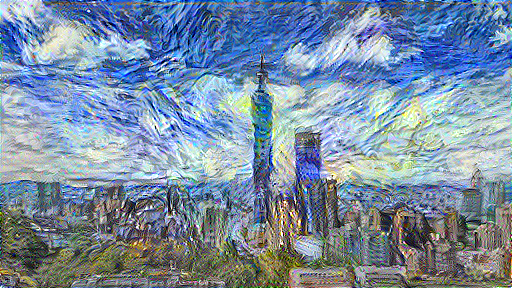

Train step: 1000  loss: 4470650.215
Total time: 30.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  tot_loss=0
  for m in range(steps_per_epoch):
    step += 1
    loss=train_step(image)
    tot_loss=tot_loss+loss.numpy()
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}  loss: {}".format(step,tot_loss/steps_per_epoch))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

-------------------------------------------分隔線-----------------------------------------------------

In [35]:
# The regularization loss associated with this is the sum of the squares of the values:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [36]:
# Choose a weight for the total_variation_loss:
total_variation_weight=30

In [37]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

In [38]:
image = tf.Variable(content_image)

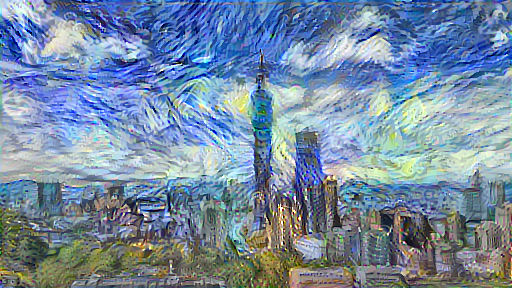

Train step: 1000  loss: [6544425.5]
Total time: 29.8


In [39]:
import time
start = time.time()
result=[]
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  tot_loss=0
  for m in range(steps_per_epoch):
    step += 1
    loss=train_step(image)
    tot_loss=tot_loss+loss.numpy()
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  tensor_to_image(image).save( "./output/{}.jpg".format(step) )
  print("Train step: {}  loss: {}".format(step,tot_loss/steps_per_epoch))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [41]:
!tar -cvf output.tar ./output/ 

./output/
./output/800.jpg
./output/900.jpg
./output/1000.jpg
./output/500.jpg
./output/300.jpg
./output/700.jpg
./output/600.jpg
./output/400.jpg
./output/200.jpg
./output/100.jpg
